In [1]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler 

In [2]:
cvrp = pd.read_csv('../Data/data.csv', index_col=0)
cvrp

,U_NODE_ID,V_NODE_ID,U_X,U_Y,V_X,V_Y,IS_DEPOT,IS_OPTIMAL_EDGE,EDGE_WEIGHT,GLOBAL_RANK,...,U_NODE_DEGREE,V_NODE_DEGREE,AVERAGE_NODE_DEGREE,U_NODE_CLUSTERING,V_NODE_CLUSTERING,AVERAGE_NODE_CLUSTERING,IS_MST_EDGE,MST_U_DEGREE,MST_V_DEGREE,MST_WEIGHT
0,1,2,82,76,96,44,1,0,34.928498,352,...,31,31,31.0,1.0,1.0,1.0,1,31,1,34.928498
1,1,3,82,76,50,5,1,0,77.878110,136,...,31,31,31.0,1.0,1.0,1.0,1,31,1,77.878110
2,1,4,82,76,49,8,1,0,75.584390,148,...,31,31,31.0,1.0,1.0,1.0,1,31,1,75.584390
3,1,5,82,76,13,7,1,0,97.580736,37,...,31,31,31.0,1.0,1.0,1.0,1,31,1,97.580736
4,1,6,82,76,29,89,1,1,54.571055,261,...,31,31,31.0,1.0,1.0,1.0,1,31,1,54.571055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46904,57,59,6,25,40,60,0,0,48.795492,204,...,59,59,59.0,1.0,1.0,1.0,0,1,1,48.795492
46905,57,60,6,25,50,4,0,0,48.754487,205,...,59,59,59.0,1.0,1.0,1.0,0,1,1,48.754487
46906,58,59,65,27,40,60,0,0,41.400483,333,...,59,59,59.0,1.0,1.0,1.0,0,1,1,41.400483
46907,58,60,65,27,50,4,0,0,27.459060,557,...,59,59,59.0,1.0,1.0,1.0,0,1,1,27.459060


In [3]:
cvrp.pop("IS_DEPOT")
cvrp.pop("U_NODE_ID")
cvrp.pop("V_NODE_ID")
cvrp.pop("U_Y")
cvrp.pop("U_X")
cvrp.pop("V_X")
cvrp.pop("V_Y")
y = cvrp.pop('IS_OPTIMAL_EDGE').values # Set this as the y (target)
X = cvrp.values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40)

scaler = MinMaxScaler()
normalised_X = scaler.fit_transform(X_train)
normalised_X.shape


(28145, 14)

In [5]:
i_scores = mutual_info_classif(normalised_X, y_train)

X_train_df = pd.DataFrame(data=normalised_X, columns=list(cvrp.columns))
X_train_df

FS_DF = pd.DataFrame(i_scores, index = X_train_df.columns, columns =['I-Gain'])
FS_DF.sort_values(by=['I-Gain'], ascending=False, inplace=True)
FS_DF

,I-Gain
V_NODE_LOCAL_EDGE_RANK,0.022033
U_NODE_LOCAL_EDGE_RANK,0.020324
MST_WEIGHT,0.019465
EDGE_WEIGHT,0.018005
MST_U_DEGREE,0.015588
IS_MST_EDGE,0.015044
GLOBAL_RANK,0.005996
V_NODE_DEGREE,0.005922
U_NODE_DEGREE,0.005151
AVERAGE_NODE_DEGREE,0.004197


In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest

best_n_features = 1
best_acc = 0
best_k = 1
best_score = []

for k in range(1, 10):
    scores = []
    model = KNeighborsClassifier(n_neighbors=k)
    for up_to_index_feature in range(1, len(FS_DF.index) + 1):
        selected_features = X_train_df[FS_DF.index[:up_to_index_feature]]
        top_selected_features = selected_features.values
        curr_acc = cross_val_score(model, top_selected_features, y_train, cv=10, scoring='f1_macro')[0]

        scores.append(curr_acc)

        if (curr_acc > best_acc):
            best_acc = curr_acc
            best_n_features = up_to_index_feature
            best_k = k
            best_score = scores
        
FS_DF.head(n=best_n_features)

,I-Gain
V_NODE_LOCAL_EDGE_RANK,0.022033
U_NODE_LOCAL_EDGE_RANK,0.020324
MST_WEIGHT,0.019465


In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

selection = SelectKBest(score_func=mutual_info_classif, k=best_n_features).fit(X_train, y_train)
X_features = selection.transform(X_train)
print(X_features.shape)

(28145, 3)


In [8]:
normalised_test_X = scaler.fit_transform(X_test)
normalised_test_X.shape

(18764, 14)

## kNN

c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     18074
           1       0.04      1.00      0.07       690

    accuracy                           0.04     18764
   macro avg       0.02      0.50      0.04     18764
weighted avg       0.00      0.04      0.00     18764

Accuracy:
0.03677254316776807

Confusion matrix:
[[    0 18074]
 [    0   690]]


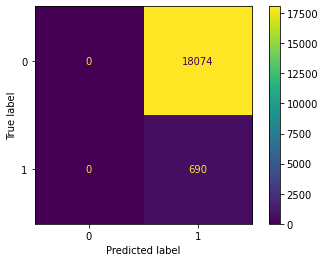

In [9]:
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_features, y_train)

X_test_features = selection.transform(normalised_test_X)
y_pred = model.predict(X_test_features)

matrix = classification_report(y_test, y_pred)
print('Classification report : \n',matrix)

print("Accuracy:\n{}".format(accuracy_score(y_test, y_pred)))

plot_confusion_matrix(model, X_test_features, y_test)
confusion = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n{}".format(confusion))

## Naive Bayes

### BernoulliNB

Classification report : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     18074
           1       0.21      0.00      0.01       690

    accuracy                           0.96     18764
   macro avg       0.59      0.50      0.49     18764
weighted avg       0.94      0.96      0.95     18764

Accuracy:
0.9628011085056492

Confusion matrix:
[[18063    11]
 [  687     3]]


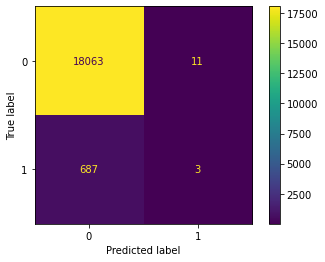

In [10]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB

model = BernoulliNB()
model.fit(X_features, y_train)

X_test_features = selection.transform(normalised_test_X)
y_pred = model.predict(X_test_features)

matrix = classification_report(y_test, y_pred)
print('Classification report : \n',matrix)

print("Accuracy:\n{}".format(accuracy_score(y_test, y_pred)))

plot_confusion_matrix(model, X_test_features, y_test)
confusion = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n{}".format(confusion))

### GaussianNB

c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     18074
           1       0.00      0.00      0.00       690

    accuracy                           0.96     18764
   macro avg       0.48      0.50      0.49     18764
weighted avg       0.93      0.96      0.95     18764

Accuracy:
0.963227456832232

Confusion matrix:
[[18074     0]
 [  690     0]]


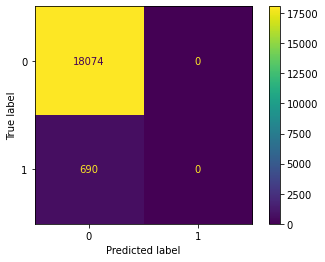

In [11]:
model = GaussianNB()
model.fit(X_features, y_train)

X_test_features = selection.transform(normalised_test_X)
y_pred = model.predict(X_test_features)

matrix = classification_report(y_test, y_pred)
print('Classification report : \n',matrix)

print("Accuracy:\n{}".format(accuracy_score(y_test, y_pred)))

plot_confusion_matrix(model, X_test_features, y_test)
confusion = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n{}".format(confusion))

## LogisticRegression

Classification report : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     18074
           1       0.00      0.00      0.00       690

    accuracy                           0.96     18764
   macro avg       0.48      0.50      0.49     18764
weighted avg       0.93      0.96      0.95     18764

Accuracy:
0.963227456832232

Confusion matrix:
[[18074     0]
 [  690     0]]


c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

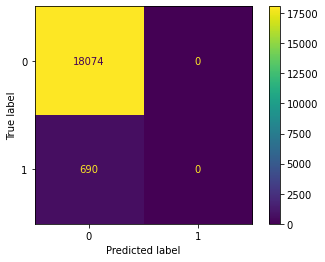

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_features, y_train)

X_test_features = selection.transform(normalised_test_X)
y_pred = model.predict(X_test_features)

matrix = classification_report(y_test, y_pred)
print('Classification report : \n',matrix)

print("Accuracy:\n{}".format(accuracy_score(y_test, y_pred)))

plot_confusion_matrix(model, X_test_features, y_test)
confusion = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n{}".format(confusion))

## DecisionTreeClassifier

Classification report : 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     18074
           1       0.01      0.01      0.01       690

    accuracy                           0.92     18764
   macro avg       0.49      0.49      0.49     18764
weighted avg       0.93      0.92      0.92     18764

Accuracy:
0.9219782562353442

Confusion matrix:
[[17290   784]
 [  680    10]]


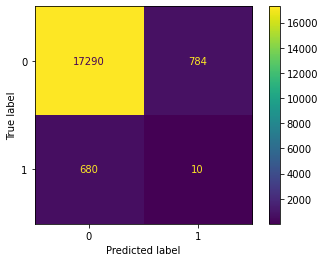

In [13]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_features, y_train)

X_test_features = selection.transform(normalised_test_X)
y_pred = model.predict(X_test_features)

matrix = classification_report(y_test, y_pred)
print('Classification report : \n',matrix)

print("Accuracy:\n{}".format(accuracy_score(y_test, y_pred)))

plot_confusion_matrix(model, X_test_features, y_test)
confusion = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n{}".format(confusion))

## SVC

c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     18074
           1       0.00      0.00      0.00       690

    accuracy                           0.96     18764
   macro avg       0.48      0.50      0.49     18764
weighted avg       0.93      0.96      0.95     18764

Accuracy:
0.963227456832232

Confusion matrix:
[[18074     0]
 [  690     0]]


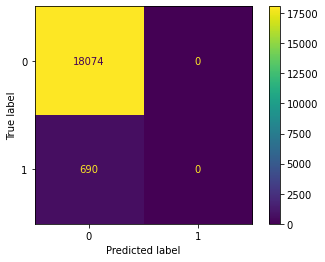

In [14]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_features, y_train)

X_test_features = selection.transform(normalised_test_X)
y_pred = model.predict(X_test_features)

matrix = classification_report(y_test, y_pred)
print('Classification report : \n',matrix)

print("Accuracy:\n{}".format(accuracy_score(y_test, y_pred)))

plot_confusion_matrix(model, X_test_features, y_test)
confusion = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n{}".format(confusion))